## Introduction figure to the path reconstruction method.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../../')

%run ../../../setup_project.py
%run ../../../generic_plot_functions.py
%run ../../../path_reconstruction/functions.py


import os.path
import shutil
from scipy.stats import wilcoxon, pearsonr
projectName, dataPath, dlcModelPath, myProject, sSessions = setup_project_session_lists(projectName="autopi_mec",dataPath="/adata/projects/autopi_mec",dlcModelPath="/adata/models")
from matplotlib.patches import FancyBboxPatch

creating myProject, an autopipy.project object
Project name: autopi_mec
dataPath: /adata/projects/autopi_mec
dlcModelPath: /adata/models
Reading /adata/projects/autopi_mec/sessionList
We have 180 testing sessions in the list
spikeA.Kilosort_session objects are in sSessions


In [2]:
boxprops = {'edgecolor': 'k', 'linewidth': 1.5}
lineprops = {'color': 'k', 'linewidth': 1.5}

boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                   'whiskerprops': lineprops, 'capprops': lineprops,
                   'width': 0.75})
stripplot_kwargs = dict({'linewidth': 1, 'size': 3.5, 'alpha': 0.8},)

OBSERVATIONCOLOR = "#00afb9"

In [3]:
#prepareSessionsForSpatialAnalysisProject(sSessions,myProject.sessionList) ### sSeslist >>>> sSessions

In [4]:
#for ses, sSes in tqdm(zip(myProject.sessionList,sSessions)):
#    getSearchHomingIntervals(ses,sSes)

In [5]:
fn = myProject.dataPath+"/results/cells.csv"
print("Loading", fn)
cells = pd.read_csv(fn)

fn=myProject.dataPath+"/results/myMaps.pickle"
print("Loading",fn)
with open(fn, 'rb') as fp: 
    myMaps = pickle.load(fp)

fn=myProject.dataPath+"/results/mapCorDf.csv"
print("Loading",fn)
dfMapCor = pd.read_csv(fn)
    
fn=myProject.dataPath+"/results/gc_pairs.csv"
print("Loading:",fn)
gc_pairs = pd.read_csv(fn)

fn=myProject.dataPath+"/results/res_ifr.csv"
print("Loading",fn)
dfAsso = pd.read_csv(fn)

Loading /adata/projects/autopi_mec/results/cells.csv
Loading /adata/projects/autopi_mec/results/myMaps.pickle


Loading /adata/projects/autopi_mec/results/mapCorDf.csv
Loading: /adata/projects/autopi_mec/results/gc_pairs.csv
Loading /adata/projects/autopi_mec/results/res_ifr.csv


## Cartesian to toroidal space transformation

We need a figure to explain how we go from the Cartesian coordinate system to the grid toroidal space.


In [6]:
fn = myProject.dataPath+"/results/sessionList_pathReconstruction.csv"
print("Loading",fn)
sessionNameList = list(pd.read_csv(fn)["session"])
sessionNameList

Loading /adata/projects/autopi_mec/results/sessionList_pathReconstruction.csv


['jp486-19032023-0108',
 'jp486-18032023-0108',
 'jp3269-28112022-0108',
 'jp486-16032023-0108',
 'jp452-25112022-0110',
 'jp486-24032023-0108',
 'jp486-22032023-0108',
 'jp452-24112022-0109',
 'jp486-15032023-0108',
 'jp3120-25052022-0107',
 'jp3120-26052022-0107',
 'jp451-28102022-0108',
 'jp486-20032023-0108',
 'jp486-06032023-0108',
 'jp486-26032023-0108',
 'jp486-17032023-0108',
 'jp451-29102022-0108',
 'jp3269-30112022-0110',
 'mn8578-23122021-0108',
 'jp451-30102022-0108',
 'jp3269-27112022-0108',
 'jp486-10032023-0108',
 'jp486-05032023-0108',
 'jp3269-29112022-0108',
 'mn8578-15122021-0107',
 'jp486-13032023-0108',
 'mn8578-17122021-0107',
 'jp3120-24052022-0108',
 'jp452-23112022-0108',
 'jp1686-29042022-0109',
 'jp1687-26052022-0107',
 'jp1686-26042022-0108',
 'jp451-27102022-0108',
 'jp451-01112022-0108',
 'jp1686-28042022-0107',
 'jp3269-26112022-0108',
 'mn8578-25122021-0107',
 'mn8578-05122021-0108',
 'jp486-02032023-0108',
 'mn8578-10122021-0107',
 'jp3129-05062022-0108

## Create a cartesian and toroidal map stack

This will be used to explained the transformation between the 2 coordinate systems

In [7]:
sessionName=sessionNameList[0]

In [8]:
rowSize,colSize= figurePanelDefaultSize()

In [9]:
cm_per_bin = 3
xy_range=np.array([[-50,-90],[50,60]])

sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions)

# Get intervals of random foraging to work with
firstTrialInter = sSes.trial_intervals.inter[0:1]

# get gridSpacePose
gridSpacePose = transform_xy_to_grid_representation(sessionName,cells,sSessions,firstTrialInter)

# get ifrs
ifrs = get_ifr_for_model(sessionName,cells,sSessions,firstTrialInter)

    
v0 = np.arctan2(gridSpacePose[0][:,1],gridSpacePose[0][:,0])
v1 = np.arctan2(gridSpacePose[0][:,3],gridSpacePose[0][:,2])

smoothing = 2
for i,n in enumerate(cg.gc_list[:10]):
    
    myMap,edges_x,edges_y,_ = stats.binned_statistic_2d(np.squeeze(v0),np.squeeze(v1),ifrs[i], statistic='mean',bins=20)
    
    myMap = ndimage.gaussian_filter(myMap,sigma=smoothing,mode="wrap")

    fig = plt.figure(figsize=(1*colSize, 1*rowSize), constrained_layout=True) # create a figure
    mainSpec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(mainSpec[0])
    
    
    ax.imshow(myMap.T,origin="lower",extent=[-np.pi,np.pi,-np.pi,np.pi])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])
    ax.axis("off")
    fn = "/adata/projects/autopi_mec/results/mapStack/toroidal_map{}.svg".format(i)
    #plt.savefig(fn)
    #print("saving",fn)
    plt.close()
    
for i,n in enumerate(cg.gc_list[:10]):
    cluName = "{}_{}".format(sessionName,n.name)
    cluIndex = cells[cells.cluId==cluName].index[0]
    fig = plt.figure(figsize=(1*colSize, 1*rowSize), constrained_layout=True) # create a figure
    mainSpec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(mainSpec[0])
    cond = "circ80_1"
    myMap = myMaps[cond][cluIndex,:,:]
    ax.imshow(myMap.T,origin="lower",   )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks(ticks=[])
    ax.set_yticks(ticks=[])
    ax.axis("off")
    fn = "/adata/projects/autopi_mec/results/mapStack/cartesian_map{}.svg".format(i)
    #plt.savefig(fn)
   # print("saving",fn)
    plt.close()

This code created a bunch of maps. I used Blender to make two stacks as a 3D plot. 


To transfer the maps to a computer with Blender
```
cd /adata/projects/autopi_mec/results
tar -czvf mapStack.tar.gz mapStack
```

```
scp a230-pc59:/adata/projects/autopi_mec/results/mapStack.tar.gz .
tar -xf mapStack.tar.gz 
```

1. Saved original maps as svg files
2. Open in inkscape and delete the background and export as png. 
3. Import the png as a plane in Blender, save redered image a png
4. Crop with the crop.sh script in the `/home/kevin/Documents/blender/map_stack/renders/` folder.
5. Copy back the cropped images to the database. 

I put the two final images in 

* `/adata/projects/autopi_mec/results/mapStack/cartesian_maps_cropped_labels.png` 
* `/adata/projects/autopi_mec/results/mapStack/toroidal_maps_cropped_labels.png` 


In [10]:
def plot_cartesian_stack(spec):
    ax = fig.add_subplot(spec[0]) # add an axes to the figure
    img = mpimg.imread('/adata/projects/autopi_mec/results/mapStack/cartesian_maps_cropped.png')
    ax.imshow(img)
    ax.text(150,930,"Y",fontsize=9)
    ax.text(640,960,"X",fontsize=9)
    ax.text(2,600,"Neurons",fontsize=9,rotation=93)
    ax.axis("off")

def plot_toroidal_stack(spec):
    ax = fig.add_subplot(spec[0]) # add an axes to the figure
    img = mpimg.imread('/adata/projects/autopi_mec/results/mapStack/toroidal_maps_cropped.png')
    ax.imshow(img)
    ax.text(150,930,"$v_{1}$",fontsize=9)
    ax.text(640,960,"$v_{0}$",fontsize=9)
    ax.text(2,600,"Neurons",fontsize=9,rotation=93)
    ax.axis("off")

saving /adata/projects/autopi_mec/results/Fig3_stack.png


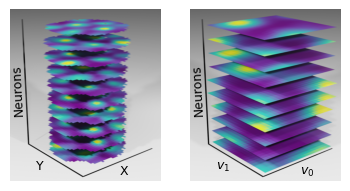

In [11]:
import matplotlib.image as mpimg
import matplotlib as mpl

rowSize,colSize= figurePanelDefaultSize()
ncols=2
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=2, nrows=1) # create a GridSpec object to a figure

cartesianSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[0])
toroidalSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[1])

plot_cartesian_stack(cartesianSpec)
plot_toroidal_stack(toroidalSpec)

fn= myProject.dataPath+"/results/Fig3_stack.png"
print("saving",fn)
plt.savefig(fn,dpi=600)
    

In [12]:
def grid_cells_in_2D(spec, sessionName, cells, sSessions):
    
    cm_per_bin = 3
    xy_range=np.array([[-50,-90],[50,60]])
    
    sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions)
    
    # 
    gridParameters = get_grid_param_transformation(sSes)
   
    
    # Get intervals of random foraging to work with
    firstTrialInter = sSes.trial_intervals.inter[0:1]
    
    # get gridSpacePose
    gridSpacePose, timePose = transform_xy_to_grid_representation(sessionName,cells,sSessions,firstTrialInter)
    
    # get ifrs
    ifrs = get_ifr_for_model(sessionName,cells,sSessions,firstTrialInter)
    ap.set_intervals(firstTrialInter)
    
    gridCellIndex=6
    
    n = cg.gc_list[gridCellIndex]
    cluId = "{}_{}".format(sSes.name,n.name)
   
    cluIndex = cells[cells.cluId==cluId].index[0]
    
    # remove invalid values from the pose
    poseLong = ap.pose[:,1:3]
    keepIndices = ~np.any(np.isnan(poseLong),1)
    pose = poseLong[keepIndices]

    
    v0 = np.arctan2(gridSpacePose[:,1],gridSpacePose[:,0])
    v1 = np.arctan2(gridSpacePose[:,3],gridSpacePose[:,2])
    v2 = np.arctan2(gridSpacePose[:,5],gridSpacePose[:,4])

    ## plot grid cells rate in xy and c0-c1-c2 space
    
    smoothing = 2
    ncols=3
    nrows=1
    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows, width_ratios=[1,0.7,1], subplot_spec=spec[0]) # two rows to give space for letters above the plots
    
    for i,j in enumerate([gridCellIndex]):
        n = cg.gc_list[j]
        ax = fig.add_subplot(mainSpec[i,0])
        cmap="jet"
        vmin=0
        alpha=1
        
        cond = "circ80_1"
        myMap = myMaps[cond][cluIndex,:,:]
        ax.imshow(myMap.T,origin="lower",interpolation=None,alpha=alpha,extent=[-50,50,-50,50])
        ax.set_title("Cartesian",fontsize=9)
        ax.set_xlabel("x position (cm)")
        ax.set_ylabel("y position (cm)") 
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)  
        V0 = gridParameters["orientation"][0]
        V1 = gridParameters["orientation"][1]
        s0 = gridParameters["period"][0]
        s1 = gridParameters["period"][1]
        v0xy = np.cos(V0)*s0,np.sin(V0)*s0
        v1xy = np.cos(V1)*s1,np.sin(V1)*s1
        origine = (0,0)
        ax.plot([origine[0],origine[0]+v0xy[0]],[origine[1],origine[1]+v0xy[1]],color="blue")
        ax.plot([origine[0],origine[0]+v1xy[0]],[origine[1],origine[1]+v1xy[1]],color="red")
        ax.text(28,30,"$v_{0}$",fontsize=11,color="blue",weight="bold")
        ax.text(-22,42,"$v_{1}$",fontsize=11,color="red",weight="bold")
            

        ax = fig.add_subplot(mainSpec[i,2])
        myMap,edges_x,edges_y,_ = stats.binned_statistic_2d(np.squeeze(v0),np.squeeze(v1),ifrs[j], statistic='mean',bins=20)
        myMap = ndimage.gaussian_filter(myMap,sigma=smoothing,mode="wrap")
        ax.imshow(myMap.T,origin="lower",extent=[-np.pi,np.pi,-np.pi,np.pi])
        ax.set_title("Toroidal",fontsize=9)
        ax.set_xlabel("$v_{0}$")
        ax.set_ylabel("$v_{1}$")
        ax.set_xticks(ticks=[-np.pi, 0, np.pi])
        ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"])
        ax.set_yticks(ticks=[-np.pi, 0, np.pi])
        ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"])

        ax.spines['left'].set_color('red')
        ax.spines['right'].set_color('red')
        ax.spines['top'].set_color('blue')
        ax.spines['bottom'].set_color('blue')

        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_linewidth(2)
        ax.spines['right'].set_linewidth(2) 
        ax.set_aspect('equal')
        

             

        mpl.rcParams['font.size'] = 12
        mpl.rcParams['text.usetex'] = True
        mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
        # you texlive installed on your computer
        ax = fig.add_subplot(spec[0])
         ## first arrow 
        ax.set_xlim(0,3.5)
        ax.set_ylim(0,1)
        
        ax.text(1.75,0.85,"Change of \ncoordinate system",fontsize=10, horizontalalignment='center')
        matrix = r"""$g(\begin{bmatrix} x \\ y \end{bmatrix}) = \begin{bmatrix} v_{0} \\ v_{1} \end{bmatrix} $"""
        ax.text(1.4,0.5,matrix,fontsize=10)
         ## second arrow 
        ax.arrow(x=1.56,y=0.74, dx=0.33,dy=0,color="black", width=0.01,
                 length_includes_head=False, head_width=0.05, head_length=0.05)

        ax.axis("off")
        mpl.rcParams['font.size'] = 9
        mpl.rcParams['text.usetex'] = False


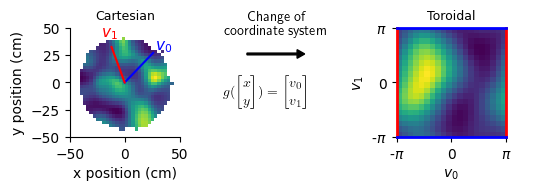

In [13]:
rowSize,colSize= figurePanelDefaultSize()
ncols=3
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1)
mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[0]) # two rows to give space for letters above the plots


sessionName=sessionNameList[0]
grid_cells_in_2D(mainSpec, sessionName, cells, sSessions)

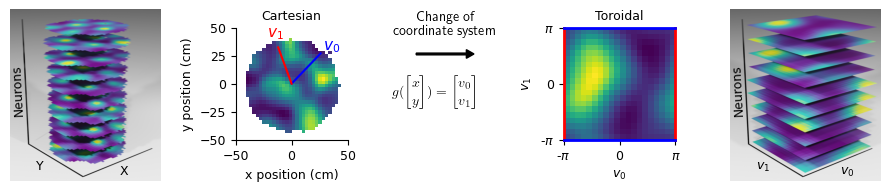

In [14]:
rowSize,colSize= figurePanelDefaultSize()
ncols=5
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure

spec = fig.add_gridspec(ncols=1, nrows=1)
mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows, subplot_spec=spec[0]) # two rows to give space for letters above the plots


cartesianSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[0])
toroidalSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[4])
transformationSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1:4])

plot_cartesian_stack(cartesianSpec)
plot_toroidal_stack(toroidalSpec)
grid_cells_in_2D(transformationSpec, sessionName, cells, sSessions)


In [15]:
def transformation_plot(spec):
    ncols=5
    nrows=1
    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows, subplot_spec=spec[0]) # two rows to give space for letters above the plots


    cartesianSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[0])
    toroidalSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[4])
    transformationSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1:4])

    plot_cartesian_stack(cartesianSpec)
    plot_toroidal_stack(toroidalSpec)
    grid_cells_in_2D(transformationSpec, sessionName, cells, sSessions)    

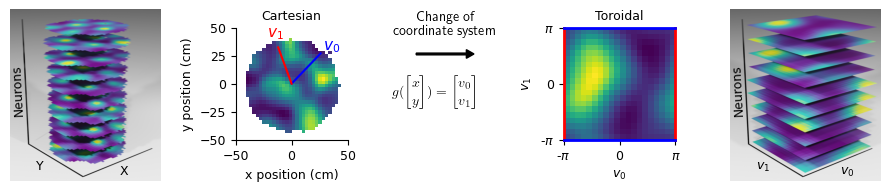

In [16]:
rowSize,colSize= figurePanelDefaultSize()
ncols=5
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1)
transformation_plot(spec)

## RNN Model and path decoding

We want one row to explain training (2 columns) and path prediction (3 columns).

* To explain training, grid cell IFR and position in v0 and v1 that are fed into a RNN.


In [17]:
def plot_ifr_matrix(ax,train_ifr,time_length=1000):
    time_length=1000
    ax.imshow(train_ifr[0:time_length].T, aspect="auto",interpolation=None,origin="lower",extent=[0,time_length*0.02,0,train_ifr.shape[1]])
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Time (sec)")

Get position data from one session to simulate some grid cells.

In [18]:
sessionName = 'jp3120-25052022-0107'
ses =[ses for ses in sSessions if ses.name == sessionName][0]

## we need the position on torus for this session
sSes, ap, apSim, cg = load_session_files_for_modelling(sessionName,cells,sSessions)
# 
gridParameters = get_grid_param_transformation(sSes)

# Get intervals of random foraging to work with
firstTrialInter = sSes.trial_intervals.inter[0:1]

# get gridSpacePose
gridSpacePose, timePose = transform_xy_to_grid_representation(sessionName,cells,sSessions,firstTrialInter)

# get ifrs
ifrs = get_ifr_for_model(sessionName,cells,sSessions,firstTrialInter)

ap.set_intervals(firstTrialInter)



In [20]:
timePose

array([   9.02,    9.04,    9.06, ..., 1812.94, 1812.96, 1812.98])

In [21]:
def ifr_plot(spec):
    
    startTime=30
    endTime=50
    
    ax = fig.add_subplot(spec[0])
    ifrsNorm = ifrs/np.expand_dims(ifrs.max(axis=1),axis=1)
    ax.imshow(ifrsNorm[:,np.logical_and(timePose>startTime,timePose<endTime)],aspect="auto",origin="lower",extent=[0,endTime-startTime,0,17],interpolation='none')
    ax.set_ylabel("Grid cells")
    ax.set_xlabel("Time (sec)")

    

saving /adata/projects/autopi_mec/results/Fig3_ifr.png


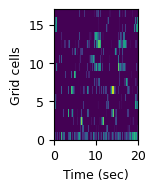

In [22]:
rowSize,colSize= figurePanelDefaultSize()
ncols=0.8
nrows=1

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1) 
ifr_plot(spec)

fn= myProject.dataPath+"/results/Fig3_ifr.png"
print("saving",fn)
plt.savefig(fn,dpi=600)

In [23]:
def training_RNN_plot(spec):
    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=2, width_ratios = [1.5,0.5], height_ratios=[0.45,0.55], subplot_spec=spec[0])
    posiSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[0,0])
    ifrSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1,0])

    startTime=30
    endTime=50

    v0 = np.arctan2(gridSpacePose[:,1],gridSpacePose[:,0])
    v1 = np.arctan2(gridSpacePose[:,3],gridSpacePose[:,2])
    
    ax = fig.add_subplot(posiSpec[0])
    ax.scatter(timePose-startTime,v0,s=2,color="blue")
    ax.scatter(timePose-startTime,v1,s=2,color="red")
    ax.set_xlim(0,endTime-startTime)
    ax.set_yticks(ticks=[-np.pi, 0, np.pi])
    ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"])
    ax.set_ylabel("Toroidal\nposition")
    #ax.set_xticklabels([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(16.5,np.pi-0.8,"$v_{0}$",fontsize=12,color="blue",weight="bold")
    ax.text(16.5,-np.pi+0.4,"$v_{1}$",fontsize=12,color="red",weight="bold")


    ax = fig.add_subplot(ifrSpec[0])
    ifrsNorm = ifrs/np.expand_dims(ifrs.max(axis=1),axis=1)
    ax.imshow(ifrsNorm[:,np.logical_and(timePose>startTime,timePose<endTime)],aspect="auto",origin="lower",extent=[0,endTime-startTime,0,17])
    ax.set_ylabel("Grid\ncells")
    ax.set_xlabel("Time (sec)")

    ax = fig.add_subplot(mainSpec[:,:])
    ax.axis("off")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    ## RNN
    p_fancy = FancyBboxPatch((0.85, 0.5),
                             0.09, 0.18,
                             boxstyle="round,pad=0.05",
                             mutation_scale=1.,
                             fc=(.8, .8, .8),
                             ec=(0.0, 0.0, 0.0))
    ax.add_patch(p_fancy)
    ax.text(0.86,0.58,"RNN")

    ## arrows
    ax.arrow(x=0.75,y=0.88, dx=0.04,dy=-0.05,color="black", width=0.01,
                 length_includes_head=False, head_width=0.05, head_length=0.05)

    ax.arrow(x=0.75,y=0.3, dx=0.04,dy=0.05,color="black", width=0.01,
                 length_includes_head=False, head_width=0.05, head_length=0.05)


saving /adata/projects/autopi_mec/results/Fig3_train.png


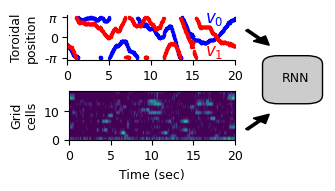

In [24]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1.8
nrows=1.0

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1) 
training_RNN_plot(spec)

fn= myProject.dataPath+"/results/Fig3_train.png"
print("saving",fn)
plt.savefig(fn,dpi=600)
    

In [25]:
def training_plot(spec):
    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=3,width_ratios=[0.1,2,0.1],height_ratios=[0.15,1,0.05], subplot_spec=spec[0])
    graphSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1,1])
    bigSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[:,:])


    training_RNN_plot(graphSpec)
    
    ax = fig.add_subplot(bigSpec[0])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    p_fancy = FancyBboxPatch((0.05, 0.05),
                                 0.9, 0.87,
                                 boxstyle="round,pad=0.05",
                                 mutation_scale=1.,
                                 alpha=0.075,color="grey")
    ax.add_patch(p_fancy)
    ax.text(0.5,1,"Training: model learns to predict $v_{0}$,$v_{1}$", fontsize=10,horizontalalignment='center')
    ax.axis("off")

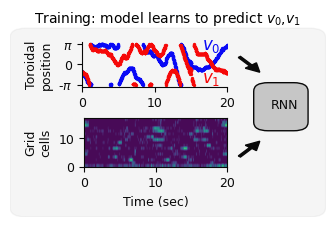

In [26]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1.8
nrows=1.2

fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1) 
training_plot(spec)
plt.show()

Now predicting

In [27]:
def feedRNN(spec):
    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1, width_ratios = [0.6, 0.3],subplot_spec=spec[0]) 
    
    ifrSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[0])
    
    startTime=50
    endTime=60

    ax = fig.add_subplot(ifrSpec[0])
    ifrsNorm = ifrs/np.expand_dims(ifrs.max(axis=1),axis=1)
    ax.imshow(ifrsNorm[:,np.logical_and(timePose>startTime,timePose<endTime)],aspect="auto",origin="lower",extent=[0,endTime-startTime,0,17])
    ax.set_ylabel("Grid cells")
    ax.set_xlabel("Time (sec)")


    ax = fig.add_subplot(mainSpec[:])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    ## arrows
    ax.arrow(x=0.61,y=0.62, dx=0.03,dy=0.0,color="black", width=0.01,
                 length_includes_head=False, head_width=0.05, head_length=0.03)


    p_fancy = FancyBboxPatch((0.75, 0.52),
                             0.08, 0.18,
                             boxstyle="round,pad=0.05",
                             mutation_scale=1.,
                             fc=(.8, .8, .8),
                             ec=(0.0, 0.0, 0.0))
    ax.add_patch(p_fancy)
    ax.text(0.71,0.60,"RNN", )


    ax.arrow(x=0.91,y=0.62, dx=0.03,dy=0.0,color="black", width=0.01,
                 length_includes_head=False, head_width=0.05, head_length=0.03)


    ax.axis("off")

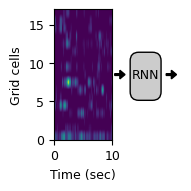

In [28]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1)
feedRNN(spec)

In [29]:
fn = myProject.dataPath+"/results/reconstuctionDFOF.csv"
print("Loading", fn)
dfOF = pd.read_csv(fn)

Loading /adata/projects/autopi_mec/results/reconstuctionDFOF.csv


In [30]:
def show_short_reconstruction_toroidal(spec):

    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=spec[0]) 


    dfSel = dfOF[dfOF.session == sessionName]
    v0 = np.arctan2(dfSel.v0_sin_smooth,dfSel.v0_cos_smooth).to_numpy()
    v1 = np.arctan2(dfSel.v1_sin_smooth,dfSel.v1_cos_smooth).to_numpy()
    lv0 = np.arctan2(dfSel.lv0_sin_smooth,dfSel.lv0_cos_smooth).to_numpy()
    lv1 = np.arctan2(dfSel.lv1_sin_smooth,dfSel.lv1_cos_smooth).to_numpy()

    startIndex=5100
    duration=300
    endIndex=startIndex+duration

    ax = fig.add_subplot(mainSpec[0])
    ax.scatter(v0[startIndex:endIndex],v1[startIndex:endIndex],alpha=0.6,label="Real",s=2)
    ax.scatter(lv0[startIndex:endIndex],lv1[startIndex:endIndex],alpha=0.6, label="Dec.",s=2)
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(-np.pi,np.pi)
    ax.set_xticks([-np.pi,0,np.pi])
    ax.set_yticks([-np.pi,0,np.pi])
    ax.set_xlabel("$v_{0}$")
    ax.set_ylabel("$v_{1}$")
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"])
    ax.set_yticklabels([r'-$\pi$', "0", "$\pi$"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_aspect("equal")
    ax.legend(loc=(-0.3,1.1),  bbox_transform=fig.transFigure,fontsize=8)

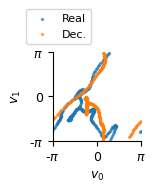

In [31]:
rowSize,colSize= figurePanelDefaultSize()
ncols=0.8
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1)

show_short_reconstruction_toroidal(spec)


In [32]:
def show_short_reconstruction_cartesian(spec):

    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=spec[0]) 


    dfSel = dfOF[dfOF.session == sessionName]
    v0 = np.arctan2(dfSel.v0_sin_smooth,dfSel.v0_cos_smooth).to_numpy()
    v1 = np.arctan2(dfSel.v1_sin_smooth,dfSel.v1_cos_smooth).to_numpy()
    lv0 = np.arctan2(dfSel.lv0_sin_smooth,dfSel.lv0_cos_smooth).to_numpy()
    lv1 = np.arctan2(dfSel.lv1_sin_smooth,dfSel.lv1_cos_smooth).to_numpy()

    startIndex=5100
    duration=300
    endIndex=startIndex+duration
    
    
    ax = fig.add_subplot(mainSpec[0])
    ax.set_aspect("equal")
    x=dfSel.x.to_numpy()[startIndex:endIndex]
    y=dfSel.y.to_numpy()[startIndex:endIndex]

    px=dfSel.px.to_numpy()[startIndex:endIndex]
    py=dfSel.py.to_numpy()[startIndex:endIndex]

    ax.scatter(np.cumsum(x),np.cumsum(y),alpha=0.6,label="Rec.",s=2)
    ax.scatter(np.cumsum(px),np.cumsum(py),alpha=0.6,label="Rec.", s=2)

    ax.set_xlabel("x (cm)")
    ax.set_ylabel("y (cm)")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

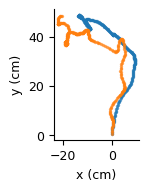

In [33]:
rowSize,colSize= figurePanelDefaultSize()
ncols=0.8
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1)

show_short_reconstruction_cartesian(spec)


In [34]:
def plot_change_of_coordinate(spec):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
    # you texlive installed on your computer
    ax = fig.add_subplot(spec[0])
     ## first arrow 
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)

    ax.text(0.5,0.85,"Change of \ncoordinate system",fontsize=10, horizontalalignment='center')
    matrix = r"""$g(\begin{bmatrix} v_{0} \\ v_{1} \end{bmatrix}) = \begin{bmatrix} x \\ y \end{bmatrix}$"""
    ax.text(0.5,0.5,matrix,fontsize=9,horizontalalignment='center')
     ## second arrow 
    ax.arrow(x=0.25,y=0.74, dx=0.5,dy=0,color="black", width=0.01,
             length_includes_head=False, head_width=0.05, head_length=0.05)

    ax.axis("off")
    mpl.rcParams['font.size'] = 9

    mpl.rcParams['text.usetex'] = False

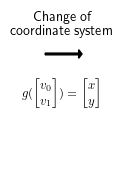

In [35]:
rowSize,colSize= figurePanelDefaultSize()
ncols=0.6
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1)
plot_change_of_coordinate(spec)

In [36]:
def plot_prediction_graphs(spec):
    ifrSpec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1,width_ratios=[1,1.8],subplot_spec=spec[0])
    ifrSpecOne = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=ifrSpec[0])
    feedRNN(ifrSpecOne)

    vSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=1,width_ratios=[0.95,0.7,1.1],subplot_spec=spec[0])
    vSpecOne = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=vSpec[1])
    show_short_reconstruction_toroidal(vSpecOne)

    cSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=1,width_ratios=[1.7,0.72,0.6],subplot_spec=spec[0])
    cSpecOne = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=cSpec[1])
    plot_change_of_coordinate(cSpecOne)



    xSpec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1,width_ratios=[2.2,0.6],subplot_spec=spec[0])
    xSpecOne = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=xSpec[1])
    show_short_reconstruction_cartesian(xSpecOne)



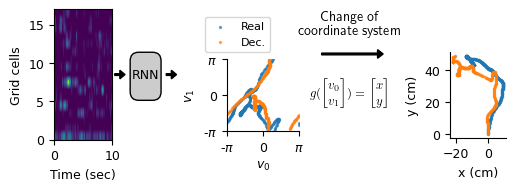

In [37]:
rowSize,colSize= figurePanelDefaultSize()
ncols=2.8
nrows=1.0
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1) 
plot_prediction_graphs(spec)

    

In [38]:
def prediction_plot(spec):
    
    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=3,width_ratios=[0.1,2,0.1],height_ratios=[0.15,1,0.05], subplot_spec=spec[0])
    graphSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[1,1])
    bigSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mainSpec[:,:])
    
    plot_prediction_graphs(graphSpec)

    ax = fig.add_subplot(bigSpec[0])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    p_fancy = FancyBboxPatch((0.05, 0.05),
                                 0.9, 0.87,
                                 boxstyle="round,pad=0.05",
                                 mutation_scale=1.,
                                 alpha=0.075,color="grey")
    ax.add_patch(p_fancy)
    ax.text(0.5,1,"Decoding of movement vectors", fontsize=10,horizontalalignment='center')
    ax.axis("off")
    

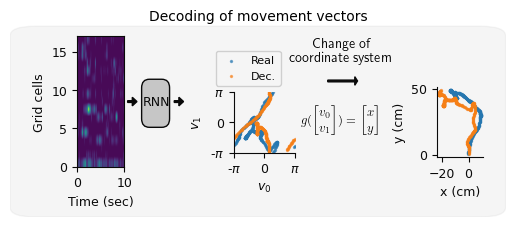

In [39]:
rowSize,colSize= figurePanelDefaultSize()
ncols=2.8
nrows=1.2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1) 


prediction_plot(spec)
    



In [40]:
def model_plot(spec):
    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=1, width_ratios=[2,0.1,3],subplot_spec=spec[0])
    trainSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=mainSpec[0])
    predSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=mainSpec[2])
    training_plot(trainSpec)
    prediction_plot(predSpec)

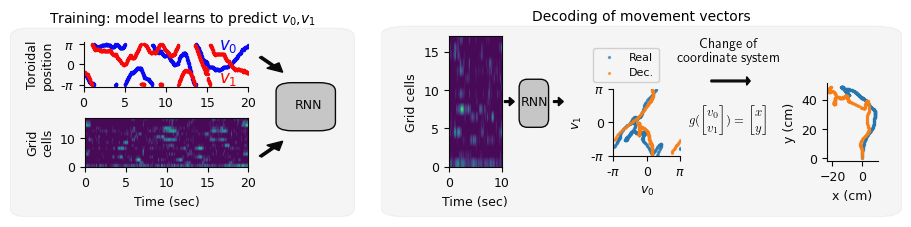

In [41]:
rowSize,colSize= figurePanelDefaultSize()
ncols=5
nrows=1.2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=1, nrows=1) 
model_plot(spec)



saving /adata/projects/autopi_mec/results/Fig3.png


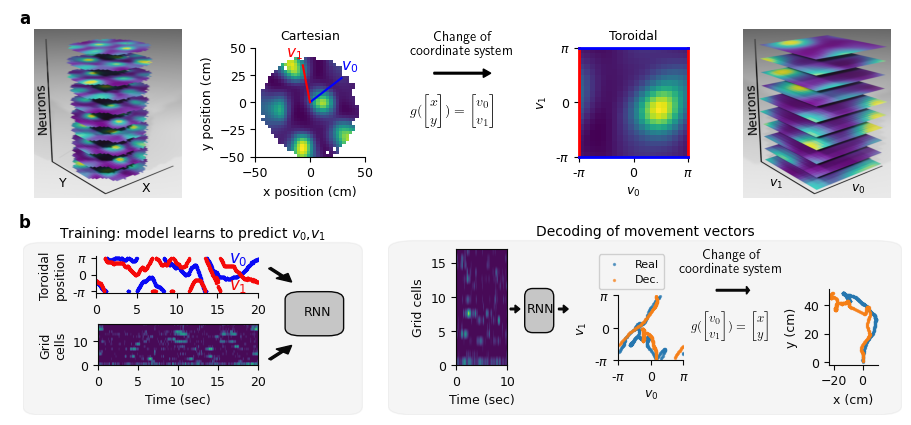

In [42]:
rowSize,colSize= figurePanelDefaultSize()
ncols=5.0
nrows=2.3
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=2, nrows=4,width_ratios=[0.01,1],height_ratios=[0.01,1,0.1,1.1]) 

transSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[1,1])
modelSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[3,1])

transformation_plot(transSpec)
model_plot(modelSpec)

ax = fig.add_subplot(spec[:,:]) # add an axes to the figure
ax.text(0.01,1, 'a', style='normal',fontsize=12, weight="bold")
ax.text(0.01,0.48, 'b', style='normal',fontsize=12, weight="bold")

ax.axis("off")

fn= myProject.dataPath+"/results/Fig3.png"
print("saving",fn)
plt.savefig(fn)

## Path reconstruction example

We now need 2 path reconstruction example from 2 mice. 


In [43]:
setFigureDefaultParameters()

In [44]:
fn = myProject.dataPath+"/results/reconstuctionDFOF.csv"
print("Loading", fn)
dfOF = pd.read_csv(fn)

Loading /adata/projects/autopi_mec/results/reconstuctionDFOF.csv


In [45]:
def recPath(ax, dfOF,cells,sSessions, sessionName='jp3269-28112022-0108',startTime=87,duration=25):
    
    
    sSes, ap , _, cg = load_session_files_for_modelling(sessionName,cells,sSessions)

    dfSel = dfOF[dfOF.session == sessionName]
    # arena
    x = np.cos(np.linspace(0,2*np.pi,100))*40 
    y = np.sin(np.linspace(0,2*np.pi,100))*40 
    ax.plot(x,y, "--",color="grey", alpha=0.5) #,label="Arena")

    # time from the start of the reconstruction
    dfSel = dfOF[dfOF.session == sessionName]
    start=dfSel.recTime.iloc[0]+startTime #
    end=start+duration
    dfSel = dfSel[dfSel.recTime.between(start,end)]
    onePose = ap.pose[np.argmin(np.abs(ap.pose[:,0]-start)),:]

    ax.scatter(onePose[1],onePose[2],color="black",s=15,zorder=2)
    ax.plot(np.cumsum(dfSel.x) + onePose[1],np.cumsum(dfSel.y)+ onePose[2], label = "Real")
    ax.plot(np.cumsum(dfSel.px)+ onePose[1],np.cumsum(dfSel.py)+ onePose[2],"--", label = "Dec.",color="C1")

    ax.set_aspect("equal")
    ax.legend()
    ax.set_xlabel("x position (cm)")
    ax.set_ylabel("y position (cm)") 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)  

    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)
    plt.legend(fontsize=5)
    plt.legend(bbox_to_anchor= (1.1,1.2),fontsize=7,ncol=2)

saving /adata/projects/autopi_mec/results/Fig3_rec.png


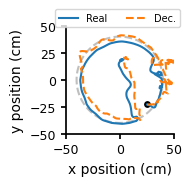

In [46]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)

ax = fig.add_subplot(mainSpec[0])
recPath(ax,dfOF,cells,sSessions,
       sessionName='jp3269-28112022-0108',startTime=87,duration=25)

fn= myProject.dataPath+"/results/Fig3_rec.png"
print("saving",fn)
#plt.savefig(fn,dpi=600)

In [47]:
fn = myProject.dataPath+"/results/reconstruction_shuffling.csv"
print('Loading', fn)

shuffleMvtError = pd.read_csv(fn,index_col=0)

Loading /adata/projects/autopi_mec/results/reconstruction_shuffling.csv


In [48]:
def mean_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.mean(np.cos(mvtDirError))
    yMean = np.mean(np.sin(mvtDirError)) 
    return np.arctan2(yMean, xMean)

def vl_mvt_direction_error(mvtDirError):
    """
    Calculate the mean direction of the mvt direction error
    """
    xMean = np.mean(np.cos(mvtDirError))
    yMean = np.mean(np.sin(mvtDirError)) 
    return np.sqrt(xMean*xMean+yMean*yMean)

def reconstruction_distribution_direction_error(ax,dfOF,cells,sSessions, sessionName1='jp3269-28112022-0108',sessionName2='mn8578-23122021-0108'):
    
    
    speed_threshold=10 # NOTE CHANGED HERE
    
    sSes, ap, _ , cg = load_session_files_for_modelling(sessionName1,cells,sSessions)     
    dfSel1 = dfOF[dfOF.session == sessionName1]  
    #meanMvtDirError = mean_mvt_direction_error(dfSel1.mvtDirError[dfSel1.speed>speed_threshold])
    vl1 = vl_mvt_direction_error(dfSel1.mvtDirError[dfSel1.speed>speed_threshold])
    
    
    sSes, ap, _ , cg = load_session_files_for_modelling(sessionName2,cells,sSessions)     
    dfSel2 = dfOF[dfOF.session == sessionName2]  
    #meanMvtDirError = mean_mvt_direction_error(dfSel1.mvtDirError[dfSel1.speed>speed_threshold])
    vl2 = vl_mvt_direction_error(dfSel2.mvtDirError[dfSel2.speed>speed_threshold])
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    hist = ax.hist(dfSel1.mvtDirError[dfSel1.speed>speed_threshold],bins=30, histtype='step',density=True,color=colors[9])
    hist = ax.hist(dfSel2.mvtDirError[dfSel2.speed>speed_threshold],bins=30, histtype='step',density=True,color=colors[6])
    
   
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Dec. directional error")
    ax.set_ylabel("Density")
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(0,1)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"])
    ax.text(-np.pi+0.2,0.85,"Directional\nprecision (MVL):".format(vl1),fontsize=9)
    # NOTE Changed here
    # ax.text(-np.pi+3.7,0.60,"{:.2f}".format(vl1),fontsize=9,color=colors[7])
    # ax.text(-np.pi+4.0,0.40,"{:.2f}".format(vl2),fontsize=9,color=colors[6])

    ax.text(-np.pi+3.7,0.60,"Acc",fontsize=9,color=colors[9])
    ax.text(-np.pi+4.0,0.40,"Inacc",fontsize=9,color=colors[6])
    
    ax.text(-np.pi+0.1,0.2,"Shuffle",fontsize=9,color='gray')
    
    #ax.text(np.pi-2.3,np.max(hist[0])-3000,"Speed\n>\n{:.0f}".format(int(speed_threshold)),fontsize=9)
    #ax.plot([meanMvtDirError,meanMvtDirError],[0,np.max(hist[0])])
    

In [49]:
def plot_shuffle_pred_dir_error(ax0,shuffleDf):
    ax0.hist(shuffleDf.mvtDirError,bins=30, histtype='step',density=True,color='gray',alpha=0.5)
#     sns.histplot(data=shuffleDf,
#             x='mvtDirError',color='gray',fill=False,lw=1,ax=ax0,alpha=0.5,stat='density', element="step",bins=30)
    
    #ax0.text(0.01,0.22,"Shuffle",fontsize=9,color='gray',transform=ax.transAxes)

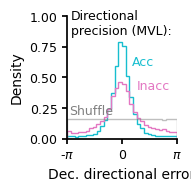

In [50]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)
ax = fig.add_subplot(mainSpec[0])
reconstruction_distribution_direction_error(ax,dfOF,cells,sSessions,sessionName1='jp3269-28112022-0108',sessionName2='jp486-17032023-0108')
plot_shuffle_pred_dir_error(ax,shuffleMvtError)


In [51]:
fn = myProject.dataPath+"/results/reconstuctionDFAutoPI.csv"
print("Loading",fn)
dfAutoPI = pd.read_csv(fn)

Loading /adata/projects/autopi_mec/results/reconstuctionDFAutoPI.csv


In [52]:
def get_non_rotated_mvt_dir_error(sessionName, cells,sSessions,dfSel):
    sSes, ap, _ , cg = load_session_files_for_modelling(sessionName,cells,sSessions) 
    grid_param_transformation = get_grid_param_transformation(sSes)
    gt = gridTransformation(period = grid_param_transformation["period"],
                       orientation = grid_param_transformation["orientation"])
    predictions  = np.stack([dfSel.v0_cos_smooth,dfSel.v0_sin_smooth,dfSel.v1_cos_smooth,dfSel.v1_sin_smooth]).T
    predMvt = gt.gridSpaceToMovementPath(predictions)
    labels  = np.stack([dfSel.lv0_cos_smooth,dfSel.lv0_sin_smooth,dfSel.lv1_cos_smooth,dfSel.lv1_sin_smooth]).T
    mvt = gt.gridSpaceToMovementPath(labels)
    mvtDirError = mvt_direction_error(mvt, predMvt)
    return mvtDirError

In [53]:
def reconstruction_distribution_direction_error_rotation(ax,dfAutoPI,cells,sSessions, sessionName1='jp3269-28112022-0108',sessionName2='mn8578-23122021-0108'):
    
    
    speed_threshold=10 
    
    sSes, ap, _ , cg = load_session_files_for_modelling(sessionName1,cells,sSessions)     
    dfSel1 = dfAutoPI[(dfAutoPI.session == sessionName1)&(dfAutoPI.condition=="all_light")]  
    mvtDirError1 = get_non_rotated_mvt_dir_error(sessionName1,cells,sSessions,dfSel1)
    meanMvtDirError1 = mean_mvt_direction_error(mvtDirError1[dfSel1.speed>speed_threshold])
    
    
    
    sSes, ap, _ , cg = load_session_files_for_modelling(sessionName2,cells,sSessions)     
    dfSel2 = dfAutoPI[(dfAutoPI.session == sessionName2)&(dfAutoPI.condition=="all_light")]  
    mvtDirError2 = get_non_rotated_mvt_dir_error(sessionName2,cells,sSessions,dfSel2)
    meanMvtDirError2 = mean_mvt_direction_error(mvtDirError2[dfSel2.speed>speed_threshold])
    
    
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    
    hist = ax.hist(mvtDirError1[dfSel1.speed>speed_threshold],bins=30, histtype='step',density=True,color=colors[9])
    hist = ax.hist(mvtDirError2[dfSel2.speed>speed_threshold],bins=30, histtype='step',density=True,color=colors[6])
    
  
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Dec. directional error")
    ax.set_ylabel("Density")
    ax.set_xlim(-np.pi,np.pi)
    ax.set_ylim(0,0.8)
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"])
    ax.text(-np.pi+0.2,0.78,"Grid rotation:",fontsize=9)

    ax.text(-np.pi+2.0,0.67,"NR",fontsize=9,color=colors[9])
    ax.text(-np.pi+4,0.66,"R",fontsize=9,color=colors[6])
    ax.text(-np.pi+0.1,0.2,"Shuffle",fontsize=9,color='gray')
    
    
   

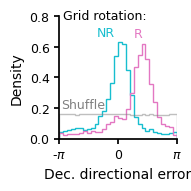

In [54]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)
ax = fig.add_subplot(mainSpec[0])
reconstruction_distribution_direction_error_rotation(ax,dfAutoPI,cells,sSessions,sessionName1='jp451-28102022-0108',sessionName2='jp452-25112022-0110')
plot_shuffle_pred_dir_error(ax,shuffleMvtError)

In [55]:
def get_nGrid(df, sSession):
    sessionName = df.session.unique().item()
    sSes =[ses for ses in sSessions if ses.name == sessionName][0]
       
    # get the number of grid cells in the model
    fn = sSes.fileBase+".rnn_ifr_normalization.pkl"
    normali = pickle.load(open(fn,"rb"))
    nGrids=normali["ifr_normalization_means"].shape[0]
    
    res = pd.DataFrame({"nGrids": [nGrids]})
    
    return res

In [56]:
dfNGrids = dfOF.groupby(["session"]).apply(get_nGrid,sSessions).reset_index().drop(columns=["level_1"])

Calculate the histogram of mvt_dir_error before any rotation to compensate for possible rotation of the grid pattern.

In [57]:
def direction_precision_matrix():
    res = []
    for sessionName in tqdm(dfNGrids.sort_values("nGrids",ascending=False).session):
        dfSel = dfOF[dfOF.session==sessionName]
        mvt_dir_error = get_non_rotated_mvt_dir_error(sessionName, cells,sSessions,dfSel)
        c,edges = np.histogram(mvt_dir_error[dfSel.speed>10],bins=np.linspace(-np.pi,np.pi,36))
        res.append(c)
    m = np.vstack(res)
    M = (m.T/m.max(axis=1)).T
    return M

In [58]:
M = direction_precision_matrix()

100%|██████████| 49/49 [01:10<00:00,  1.45s/it]


In [59]:
def direction_precision_matrix_plot(ax,M):
    ax.imshow(M,interpolation="None",extent=[-np.pi,np.pi,0,M.shape[0]],aspect="auto")
    
    ax.set_xlabel("Dec. directional error")
    ax.set_ylabel("Session")
    ax.set_xticks(ticks=[-np.pi, 0, np.pi])
    ax.set_xticklabels([r'-$\pi$', "0", "$\pi$"])
    ax.set_title("RF2",fontsize=9)
    


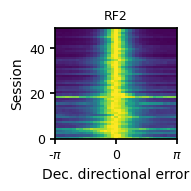

In [60]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)
ax = fig.add_subplot(mainSpec[0])
direction_precision_matrix_plot(ax,M)


Get the mean vector length at different speed.

In [61]:
def get_mvl_at_speed(df,speed_min=0, speed_max=10):
    vl = vl_mvt_direction_error(df.mvtDirError[(df.speed>speed_min)&(df.speed<speed_max)])
    mid_speed = speed_min+(speed_max-speed_min)/2
    mouse = df.mouse.unique().item()
    res = pd.DataFrame({"vl": [vl],
                 "speed": [mid_speed],
                 "mouse": [mouse]})
    return res 
res = []
for speed in [0, 5,10,15,20,25,30]:
    res.append(dfOF.groupby(["session"]).apply(get_mvl_at_speed,speed,speed+5))

res = pd.concat(res).reset_index().drop(columns=["level_1"])

In [62]:
df = pd.merge(res,dfNGrids)
df

,session,vl,speed,mouse,nGrids
0,jp1084-05042022-0107,0.073684,2.5,jp1084,5
1,jp1084-05042022-0107,0.254942,7.5,jp1084,5
2,jp1084-05042022-0107,0.368665,12.5,jp1084,5
3,jp1084-05042022-0107,0.450468,17.5,jp1084,5
4,jp1084-05042022-0107,0.477002,22.5,jp1084,5
...,...,...,...,...,...
338,mn8599-11022022-0107,0.117058,12.5,mn8599,5
339,mn8599-11022022-0107,0.149828,17.5,mn8599,5
340,mn8599-11022022-0107,0.169161,22.5,mn8599,5
341,mn8599-11022022-0107,0.148868,27.5,mn8599,5


In [63]:
def calculatePvalue(Pvalue):
    """
    Calculate the symbol to plot based on the given p-value.

    Parameters:
        Pvalue (float): The p-value to calculate the symbol for.

    Returns:
        str: The symbol to plot based on the p-value.
    """

    
    if Pvalue < 0.0001:
        symbolToPlot = '****'
    elif Pvalue < 0.001:
        symbolToPlot = '***'
    elif Pvalue < 0.01:
        symbolToPlot = '**'
    elif Pvalue < 0.05:
        symbolToPlot = '*'
    else:
        symbolToPlot = 'ns'

    return symbolToPlot

def nGrid_mvl_plot(ax,df,printStats=True):
    dfSel = df[df.speed==17.5] # NOTE Speed changed here
    gfg = sns.scatterplot(data = dfSel, x = dfSel["nGrids"], y = dfSel["vl"]) #, hue = dfSel["mouse"] )
    ax.set_ylim(0,1)
    ax.set_xlabel("Grid cells")
    ax.set_ylabel("Direct. precision")
    ax.set_xlim(3,45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend([],[], frameon=False)
    if printStats:
        print("Pearson correlation, number grid cells, pred MVL:")
        r,pValue = pearsonr(dfSel["nGrids"],dfSel["vl"])
        print("N:{}, r:{}, p:{}".format(len(dfSel.nGrids),r,pValue))
   
    x = dfSel["nGrids"]
    y = dfSel["vl"]
    z = np.polyfit(np.log(x), y, 2)
    p = np.poly1d(z)
    X = np.linspace(np.min(x),np.max(x),100)
    Y = p(np.log(X))
    ax.plot(X,Y,color="red")
    print(pValue)
    
    if pValue < 0.0001:
        
        ax.text(0.5,0.95,calculatePvalue(pValue), va='center', ha='center',transform = ax.transAxes)
        

Pearson correlation, number grid cells, pred MVL:
N:49, r:0.7361451243210786, p:1.6663404908836179e-09
1.6663404908836179e-09


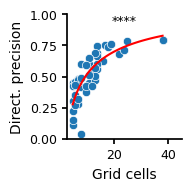

In [64]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(mainSpec[0])
nGrid_mvl_plot(ax,df)

In [65]:
def nGrid_mvl_plot(ax,df,printStats=True):
    dfSel = df[df.speed==17.5]
    gfg = sns.scatterplot(data = dfSel, x = dfSel["nGrids"], y = dfSel["vl"]) #, hue = dfSel["mouse"] )
    ax.set_ylim(0,1)
    ax.set_xlabel("Grid cells")
    ax.set_ylabel("Direct. precision")
    ax.set_xlim(3,45)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend([],[], frameon=False)
    if printStats:
        print("Pearson correlation, number grid cells, pred MVL:")
        r,pValue = pearsonr(dfSel["nGrids"],dfSel["vl"])
        print("N:{}, r:{}, p:{}".format(len(dfSel.nGrids),r,pValue))
   
    x = dfSel["nGrids"]
    y = dfSel["vl"]
    z = np.polyfit(np.log(x), y, 2)
    p = np.poly1d(z)
    X = np.linspace(np.min(x),np.max(x),100)
    Y = p(np.log(X))
    ax.plot(X,Y,color="red")
    
    print(pValue)
    
    if pValue < 0.0001:
        
        ax.text(0.5,0.95,calculatePvalue(pValue), va='center', ha='center',transform = ax.transAxes)

In [66]:
def medianToroidalDistance(df,minSpeed=10):
    df = df[df.speed> minSpeed]
    # get the v0 and v1 angle for both real and predicted 
    lv0 = np.arctan2(df.lv0_sin_smooth,df.lv0_cos_smooth)
    lv1 = np.arctan2(df.lv1_sin_smooth,df.lv1_cos_smooth)
    v0 = np.arctan2(df.v0_sin_smooth,df.v0_cos_smooth)
    v1 = np.arctan2(df.v1_sin_smooth,df.v1_cos_smooth)

    # get the angle between v0 and lv0, and v1 and lv1
    dv0 = np.arctan2(np.sin(v0-lv0), np.cos(v0-lv0))
    dv1 = np.arctan2(np.sin(v1-lv1), np.cos(v1-lv1))

    # get the distance on the torus between prediected and actual position
    errorRad = np.sqrt((dv0)**2+(dv1)**2)
    return np.nanmedian(errorRad)

toroidalError = dfOF.groupby(["session"]).apply(medianToroidalDistance).reset_index()
toroidalError.columns = ["session","error"]   
dfError = pd.merge(toroidalError,dfNGrids)

In [67]:
dfSel = dfOF[dfOF.session == sessionName]

Pearson correlation, number grid cells, distance:
N:49, r:-0.6985595186251373, p:2.391371886710721e-08


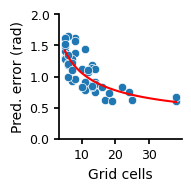

In [68]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=nrows)
ax = fig.add_subplot(mainSpec[0])
def toroidalDistancePlot(ax,dfError,printStats=True):
    gfg = sns.scatterplot(data = dfSel, x = dfError["nGrids"], y = dfError["error"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel("Grid cells")
    ax.set_ylabel("Pred. error (rad)")
    ax.set_ylim(0,2)
    if printStats:
        print("Pearson correlation, number grid cells, distance:")
        r,p = pearsonr(dfError["nGrids"],dfError["error"])
        print("N:{}, r:{}, p:{}".format(len(dfError.nGrids),r,p))
   
    x = dfError["nGrids"]
    y = dfError["error"]
    z = np.polyfit(np.log(x), y, 2)
    p = np.poly1d(z)
    X = np.linspace(np.min(x),np.max(x),100)
    Y = p(np.log(X))
    ax.plot(X,Y,color="red")
    
toroidalDistancePlot(ax,dfError)


In [69]:
from scipy.stats import friedmanchisquare

In [70]:
def mvl_speed_plot(ax,df,printStats=True):
    c = sns.color_palette()[0]

    g=sns.boxplot(data=df, x="speed",y="vl",color=c)
    ax.set_xlabel("Speed (cm/sec)")
    ax.set_ylabel("Pred. MVL")
    ax.set_ylim(0,1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    if printStats:
        stat,p =  friedmanchisquare(df.vl[df.speed==2.5],
                          df.vl[df.speed==7.5],
                          df.vl[df.speed==12.5],
                           df.vl[df.speed==17.5],
                           df.vl[df.speed==22.5],
                           df.vl[df.speed==27.5],
                           df.vl[df.speed==32.5]
                         )
        print("Friedman test on speed MVL:")
        print("N = {}, stats: {}, P = {}".format(len(df.vl[df.speed==7.5]),stat,p))
    

Friedman test on speed MVL:
N = 49, stats: 269.7463556851312, P = 2.4580125733755305e-55


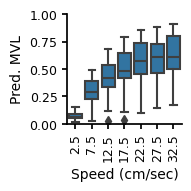

In [71]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(mainSpec[0])
mvl_speed_plot(ax,df)

Pearson correlation, number grid cells, pred MVL:
N:49, r:0.7361451243210786, p:1.6663404908836179e-09
1.6663404908836179e-09


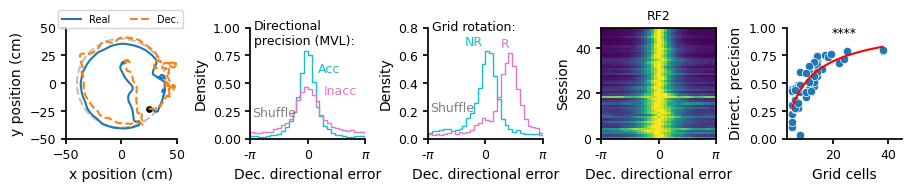

In [72]:
rowSize,colSize= figurePanelDefaultSize()
ncols=5
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1)
divSpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows,subplot_spec=mainSpec[0]) 

ax = fig.add_subplot(divSpec[0])
recPath(ax,dfOF,cells,sSessions,
       sessionName='jp3269-28112022-0108',startTime=87,duration=25)


ax = fig.add_subplot(divSpec[1])
reconstruction_distribution_direction_error(ax,dfOF,cells,sSessions,sessionName1='jp3269-28112022-0108',sessionName2='jp486-17032023-0108')
ax = fig.add_subplot(divSpec[2])
reconstruction_distribution_direction_error_rotation(ax,dfAutoPI,cells,sSessions,sessionName1='jp451-28102022-0108',sessionName2='jp452-25112022-0110')
ax = fig.add_subplot(divSpec[3])
direction_precision_matrix_plot(ax,M)
ax = fig.add_subplot(divSpec[4])
nGrid_mvl_plot(ax,df)


In [73]:

def statsRowOld(mainSpec):
    divSpec = gridspec.GridSpecFromSubplotSpec(ncols=5, nrows=1,subplot_spec=mainSpec[0]) 

    ax = fig.add_subplot(divSpec[0])
    recPath(ax,dfOF,cells,sSessions,
           sessionName='jp3269-28112022-0108',startTime=87,duration=25)

    ax = fig.add_subplot(divSpec[1])
    reconstruction_distribution_direction_error(ax,dfOF,cells,sSessions,sessionName='jp3269-28112022-0108')

    ax = fig.add_subplot(divSpec[2])
    toroidalDistancePlot(ax,dfError)


    ax = fig.add_subplot(divSpec[3])
    nGrid_mvl_plot(ax,df)
    ax = fig.add_subplot(divSpec[4])
    mvl_speed_plot(ax,df)


def statsRowNew(mainSpec):
    divSpec = gridspec.GridSpecFromSubplotSpec(ncols=5, nrows=1,subplot_spec=mainSpec[0]) 

    ax = fig.add_subplot(divSpec[0])
    recPath(ax,dfOF,cells,sSessions,
       sessionName='jp3269-28112022-0108',startTime=87,duration=25)

    ax = fig.add_subplot(divSpec[1])
    plot_shuffle_pred_dir_error(ax,shuffleMvtError)
    reconstruction_distribution_direction_error(ax,dfOF,cells,sSessions,sessionName1='jp3269-28112022-0108',sessionName2='jp486-17032023-0108')
    ax = fig.add_subplot(divSpec[2])
    plot_shuffle_pred_dir_error(ax,shuffleMvtError)
    reconstruction_distribution_direction_error_rotation(ax,dfAutoPI,cells,sSessions,sessionName1='jp451-28102022-0108',sessionName2='jp452-25112022-0110')
    ax = fig.add_subplot(divSpec[3])
    direction_precision_matrix_plot(ax,M)
    ax = fig.add_subplot(divSpec[4])
    nGrid_mvl_plot(ax,df)


Pearson correlation, number grid cells, pred MVL:
N:49, r:0.7361451243210786, p:1.6663404908836179e-09
1.6663404908836179e-09


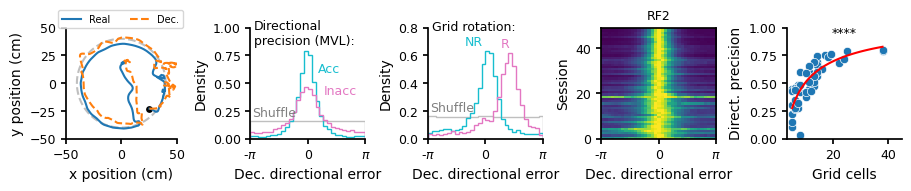

In [74]:
rowSize,colSize= figurePanelDefaultSize()
ncols=5
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1)

statsRowNew(mainSpec)

Pearson correlation, number grid cells, pred MVL:
N:49, r:0.7361451243210786, p:1.6663404908836179e-09
1.6663404908836179e-09
saving /adata/projects/autopi_mec/results/Fig3.png


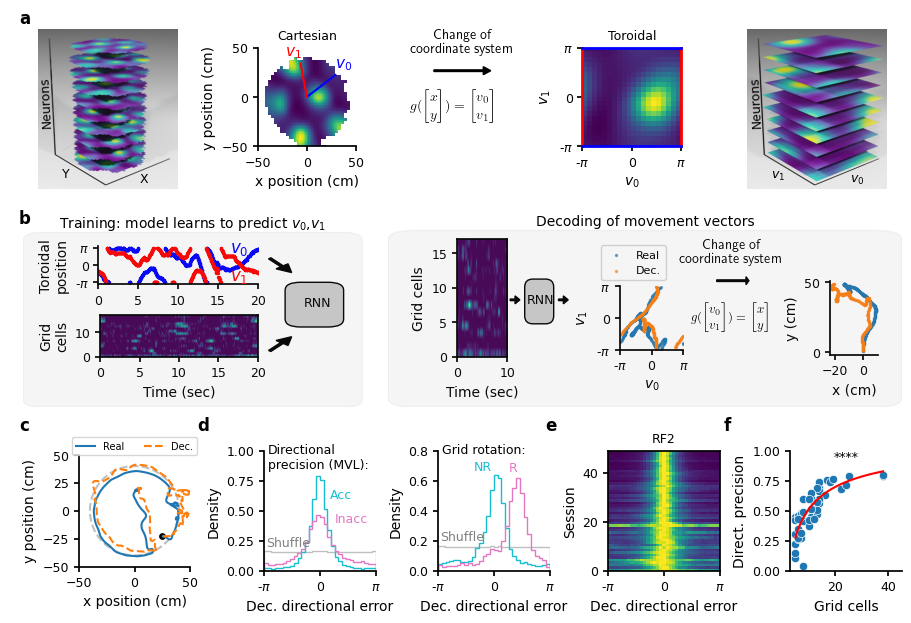

In [75]:
rowSize,colSize= figurePanelDefaultSize()
ncols=5.0
nrows=3.4
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=2, nrows=6,width_ratios=[0.01,1],height_ratios=[0.01,1,0.1,1.2,0.1,1.1]) 

transSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[1,1])
modelSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[3,1])
statsSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[5,1])

transformation_plot(transSpec)
model_plot(modelSpec)
statsRowNew(statsSpec)

ax = fig.add_subplot(spec[:,:]) # add an axes to the figure
ax.text(0.01,1, 'a', style='normal',fontsize=12, weight="bold")
ax.text(0.01,0.66, 'b', style='normal',fontsize=12, weight="bold")
ax.text(0.01,0.31, 'c', style='normal',fontsize=12, weight="bold")
ax.text(0.21,0.31, 'd', style='normal',fontsize=12, weight="bold")
#ax.text(0.42,0.31, 'e', style='normal',fontsize=12, weight="bold")
ax.text(0.60,0.31, 'e', style='normal',fontsize=12, weight="bold")
ax.text(0.80,0.31, 'f', style='normal',fontsize=12, weight="bold")

ax.axis("off")

fn= myProject.dataPath+"/results/Fig3.png"
print("saving",fn)
#plt.savefig(fn)

## Example of path reconstructions on the AutoPI task during light and dark trials

In [76]:
dfAutoPI.columns

Index(['index', 'mouse', 'session', 'condition', 'trial', 'trialNo', 'xPose',
       'yPose', 'hdPose', 'x', 'y', 'px', 'py', 'withinPathTime', 'recTime',
       'speed', 'distance', 'v0_cos', 'v0_sin', 'v1_cos', 'v1_sin', 'lv0_cos',
       'lv0_sin', 'lv1_cos', 'lv1_sin', 'mvtDirError', 'absMvtDirError',
       'shortCondition', 'light', 'path', 'v0_cos_smooth', 'v0_sin_smooth',
       'v1_cos_smooth', 'v1_sin_smooth', 'lv0_cos_smooth', 'lv0_sin_smooth',
       'lv1_cos_smooth', 'lv1_sin_smooth', 'pSpeed'],
      dtype='object')

In [77]:
dfAutoPI.condition.unique()

array(['all_light', 'all_dark', 'searchToLeverPath_light',
       'searchToLeverPath_dark', 'homingFromLeavingLever_light',
       'homingFromLeavingLever_dark',
       'homingFromLeavingLeverToPeriphery_light',
       'homingFromLeavingLeverToPeriphery_dark',
       'searchToLeverPathWithBridge_light',
       'searchToLeverPathWithBridge_dark',
       'homingFromLeavingLeverWithBridge_light',
       'homingFromLeavingLeverWithBridge_dark', 'atLever_light',
       'atLever_dark'], dtype=object)

In [78]:
def plot_paths_on_arena(ax,sessionName,condition,trials):
    """
    Plot a single trial on the arena
    """
    myColors = sns.color_palette()
    
    # arena
    x = np.cos(np.linspace(0,2*np.pi,100))*40 
    y = np.sin(np.linspace(0,2*np.pi,100))*40 
    ax.plot(x,y, "--",color="grey", alpha=0.5) #,label="Arena")
    ax.set_aspect("equal")

    paths = dfAutoPI[(dfAutoPI.session==sessionName) & (dfAutoPI.condition==condition) & (dfAutoPI.trial.isin(trials))]

    for i, trial in enumerate(trials):
        path = paths[paths.trial==trial]
        if len(path.xPose)==0:
            raise ValueError("No path data for trial {}".format(trial))

        startX = path.xPose.iloc[0]
        startY = path.yPose.iloc[0]
        #print("Trial",trial, "start x,y",startX,startY)
        ax.plot(startX+np.cumsum(path.x),startY+np.cumsum(path.y),color = myColors[0],label = "Real")
        ax.plot(startX+np.cumsum(path.px),startY+np.cumsum(path.py),"--", color = "C1",label = "Dec.")
        
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)
    ax.axis("off")
def plot_trial_array(mainSpec,ncols,nrows,
                     sessionName,condition,trials):
    """
    Plot several trials in an array
    """

    mySpec = gridspec.GridSpecFromSubplotSpec(ncols=ncols, nrows=nrows, subplot_spec=mainSpec[0])
    for i, trial in enumerate(trials):
        x = int(i%4)
        y = int(i/4)
        ax = fig.add_subplot(mySpec[y,x])
        plot_paths_on_arena(ax,sessionName,condition,[trial])


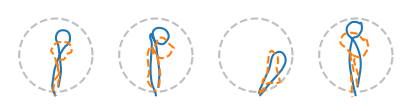

In [79]:
rowSize,colSize= 1.0,1.0 #figurePanelDefaultSize()
ncols=4
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1)

sessionName = "jp3269-28112022-0108"
condition = 'all_light'
trials = [3,4,5,12]

plot_trial_array(mainSpec,ncols,nrows,
                     sessionName,condition,trials)

In [80]:
def plot_light_dark_trial_array(mainSpec):
    
    mySpec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=4,width_ratios=[0.01,1],height_ratios = [0.01,1,0.01,1],subplot_spec=mainSpec[0])
    
    lightSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mySpec[1,:])
    darkSpec =  gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=mySpec[3,:])

    # light trials
    sessionName = "jp3269-28112022-0108"
    condition = 'all_light'
    trials = [3,4,5]
    ncols=len(trials)
    plot_trial_array(lightSpec,ncols=ncols,nrows=1,
                     sessionName=sessionName,condition=condition,trials=trials)
    # dark trials
    sessionName = "jp3269-28112022-0108"
    condition = 'all_dark'
    trials = [9,10,13]
    ncols=len(trials)
    plot_trial_array(darkSpec,ncols=ncols,nrows=1,
                     sessionName=sessionName,condition=condition,trials=trials)
    
    ax = fig.add_subplot(mySpec[:,:])
    ax.text(0.5,0.98, "Light trials",fontsize=9,horizontalalignment='center')
    ax.text(0.5,0.48, "Dark trials",fontsize=9,horizontalalignment='center')
    ax.axis("off")

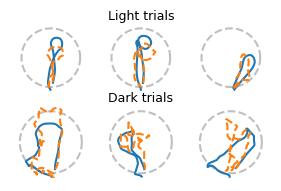

In [81]:
rowSize,colSize= 0.9,0.9 #figurePanelDefaultSize()
ncols=3
nrows=2
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1)
plot_light_dark_trial_array(mainSpec)

## General stats about the reconstruction during the AutoPI task

* Rotation from AutoPI trial
* Stability between trials in one animal

In [82]:
selectedSessionNames = ['jp486-19032023-0108', 'jp486-18032023-0108',
       'jp3269-28112022-0108', 'jp486-16032023-0108',
       'jp452-25112022-0110', 'jp486-24032023-0108',
       'jp486-22032023-0108', 'jp452-24112022-0109',
       'jp486-15032023-0108', 'jp3120-25052022-0107',
       'jp3120-26052022-0107', 'jp451-28102022-0108',
       'jp486-20032023-0108', 'jp486-06032023-0108',
       'jp486-26032023-0108', 'jp486-17032023-0108',
       'jp451-29102022-0108', 'jp451-30102022-0108',
       'jp486-10032023-0108', 'jp486-05032023-0108',
       'jp3269-29112022-0108', 'mn8578-17122021-0107',
       'jp452-23112022-0108', 'jp1686-26042022-0108']


In [83]:
gridRotationDf = get_grid_rotation_df(myProject)


In [84]:
def plotGridRotation(ax):
    gridRotationDf = get_grid_rotation_df(myProject)
    
    gridRotationDf = gridRotationDf[gridRotationDf.session.isin(selectedSessionNames)]
    
    gridRotationDf.light[gridRotationDf.condition=="RF"] = "RF"
    
    gridRotationDf["mouse"] = gridRotationDf.session.str.split("-").str[0]
    gridRotationDf["light_name"] = gridRotationDf["light"].str.capitalize()
    gridRotationDf["light_name"] = gridRotationDf["light_name"].str[0]
    gridRotationDf["light_name"][gridRotationDf["light_name"]=="R"] = "RF2"
    
    
    
    #sns.violinplot(data=gridRotationDf,x="light_name",y="rotation") #,hue="mouse")
    sns.stripplot(data=gridRotationDf,x="light_name",y="rotation",order=["RF2","L","D"],color=OBSERVATIONCOLOR, **stripplot_kwargs) #,hue="mouse"),alpha=0.5,size=3
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel("Grid rotation\n (from RF1)")
    ax.set_xlabel("Task")
    ax.set_ylim(-np.pi/2-0.3,np.pi/2+0.3)
    ax.set_yticks(ticks=[-np.pi/2, 0, np.pi/2])
    ax.set_yticklabels([r'-$\pi/2$', "0", "$\pi/2$"])
    #ax.legend(ncol=2, fancybox=False,fontsize=7,markerscale=0.5)


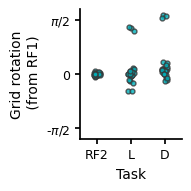

In [85]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1)
ax = fig.add_subplot(mainSpec[0])
plotGridRotation(ax)

In [86]:
gridRotationDf = get_grid_rotation_df(myProject)
gridRotationDf = gridRotationDf[gridRotationDf.session.isin(selectedSessionNames)]
gridRotationDf[~gridRotationDf.rotation.between(-np.pi/5,np.pi/5)]

,session,condition,light,rotation,light_name
73,jp452-23112022-0108,all_dark,dark,1.694736,Dark
74,jp452-23112022-0108,all_light,light,1.330189,Light
76,jp452-24112022-0109,all_dark,dark,1.668197,Dark
77,jp452-24112022-0109,all_light,light,1.346918,Light
79,jp452-25112022-0110,all_dark,dark,1.615877,Dark
80,jp452-25112022-0110,all_light,light,1.239765,Light


In [87]:
def vl_wrapper(df):
    return  vl_mvt_direction_error(df.mvtDirError)

In [88]:
minSpeed = 10
maxSpeed = 50
dfOFSel = dfOF[(dfOF.speed > minSpeed)&(dfOF.speed< maxSpeed)&(dfOF.session.isin(selectedSessionNames))]
dfAutoPISel =  dfAutoPI[(dfAutoPI.speed > minSpeed) & (dfAutoPI.speed < maxSpeed)& (dfAutoPI.shortCondition.isin(["L","D"])) & (dfAutoPI.session.isin(selectedSessionNames))]

cols = ["mouse","session","shortCondition","mvtDirError"]
df1 = pd.concat([dfAutoPISel[cols], dfOFSel[cols]])
res1 = df1.groupby(["session","shortCondition"]).apply(vl_wrapper).reset_index()
res1

,session,shortCondition,0
0,jp1686-26042022-0108,D,0.451686
1,jp1686-26042022-0108,L,0.484346
2,jp1686-26042022-0108,RF,0.577187
3,jp3120-25052022-0107,D,0.200180
4,jp3120-25052022-0107,L,0.302326
...,...,...,...
67,jp486-26032023-0108,L,0.614446
68,jp486-26032023-0108,RF,0.569038
69,mn8578-17122021-0107,D,0.324634
70,mn8578-17122021-0107,L,0.459411


In [89]:
def plot_mvl_per_condition(ax,printStats=True):
    minSpeed = 10
    maxSpeed = 50
    dfOFSel = dfOF[(dfOF.speed > minSpeed)&(dfOF.speed< maxSpeed)&(dfOF.session.isin(selectedSessionNames))]
    dfAutoPISel =  dfAutoPI[(dfAutoPI.speed > minSpeed) & (dfAutoPI.speed < maxSpeed)& (dfAutoPI.shortCondition.isin(["L","D"])) & (dfAutoPI.session.isin(selectedSessionNames))]
    
    cols = ["mouse","session","shortCondition","mvtDirError"]
    df = pd.concat([dfAutoPISel[cols], dfOFSel[cols]])
    res = df.groupby(["session","shortCondition"]).apply(vl_wrapper).reset_index()
    
    res.columns = ["session","shortCondition","mvl"]
    res.shortCondition[res.shortCondition=="RF"] = "RF2"
    sns.boxplot(data=res,x="shortCondition",y="mvl", order=["RF2","L","D"],color="grey")
    sns.stripplot(data=res,x="shortCondition",y="mvl", order=["RF2","L","D"],size=3,color="black",alpha=0.5) #,hue="mouse")
    ax.set_ylim(0,1)
   # ax.set_xlabel("Trial condition")
    ax.set_xlabel("Task")
    ax.set_ylabel("Direct. precision")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if printStats:
        print("Stats on prediction heading accuracy in RF, L and D conditions")
        stat,P = wilcoxon(x=res.mvl[res.shortCondition=="RF2"] , y=res.mvl[res.shortCondition=="L"])
        print("Wilcoxon test RF2-L, N: {}, stats: {}, P = {}".format(len(res.mvl[res.shortCondition=="RF2"]),stat,P))
        stat,P = wilcoxon(x=res.mvl[res.shortCondition=="L"] , y=res.mvl[res.shortCondition=="D"])
        print("Wilcoxon test L-D, N: {}, stats: {}, P = {}".format(len(res.mvl[res.shortCondition=="D"]),stat,P))
              
   

Stats on prediction heading accuracy in RF, L and D conditions
Wilcoxon test RF2-L, N: 24, stats: 35.0, P = 0.0004944801330566406
Wilcoxon test L-D, N: 24, stats: 3.0, P = 5.960464477539062e-07
saving /adata/projects/autopi_mec/results/pathRecTask_c.png


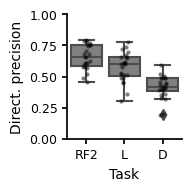

In [90]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=1)
ax = fig.add_subplot(mainSpec[0])
plot_mvl_per_condition(ax)

fn= myProject.dataPath+"/results/pathRecTask_c.png"
print("saving",fn)
plt.savefig(fn,dpi=1200)

Stats on prediction heading accuracy in RF, L and D conditions
Wilcoxon test RF2-L, N: 24, stats: 35.0, P = 0.0004944801330566406
Wilcoxon test L-D, N: 24, stats: 3.0, P = 5.960464477539062e-07


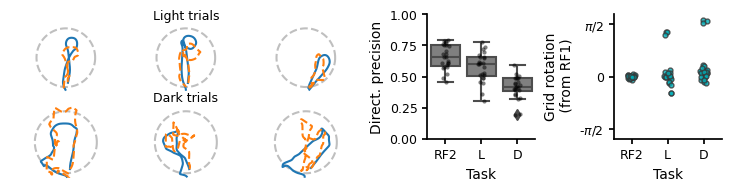

In [91]:
rowSize,colSize= figurePanelDefaultSize()
setFigureDefaultParameters()
ncols=4
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=3, nrows=1,width_ratios=[2,1,1])

pathSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=mainSpec[0])
plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=2, nrows=1,subplot_spec=mainSpec[1:])


plot_light_dark_trial_array(pathSpec)

ax = fig.add_subplot(plotSpec[0])
plot_mvl_per_condition(ax)
ax = fig.add_subplot(plotSpec[1])
plotGridRotation(ax)


## Increase in error accumulation at the lever

We want to show that error accumulation is increasing rapidely when the animal approaches the lever.

The dataframe for the figure is saved and we load it here to add the graph to our figure.



In [92]:
fn = myProject.dataPath+"/results/model_distance_with_bins.csv"
if os.path.exists(fn):
    print(fn, "exists")
df_model_distance = pd.read_csv(fn)

/adata/projects/autopi_mec/results/model_distance_with_bins.csv exists


In [93]:
df_model_distance

,Unnamed: 0,index,mouse,session,condition,trial,trialNo,xPose,yPose,hdPose,...,predictedCoordv0,predictedCoordv1,actualCoordv0,actualCoordv1,ActualCoordx,ActualCoordy,ActualCoordpx,ActualCoordpy,distance_pred_to_actual,bin
0,0,1,jp486,jp486-19032023-0108,all_dark,0,9,2.043137,-33.734406,1.178170,...,1.828885,-2.978365,2.540956,0.435404,2.199037,-33.566457,2.268699,-33.340063,0.236869,0
1,1,2,jp486,jp486-19032023-0108,all_dark,0,9,2.329532,-33.361725,1.164291,...,1.908318,-2.921590,2.583366,0.455286,2.374909,-33.384725,2.502383,-32.911675,0.489925,0
2,2,3,jp486,jp486-19032023-0108,all_dark,0,9,2.625607,-32.986565,1.149101,...,1.990715,-2.860777,2.628558,0.475566,2.566314,-33.194900,2.736151,-32.459380,0.754873,0
3,3,4,jp486,jp486-19032023-0108,all_dark,0,9,2.937955,-32.605864,1.135558,...,2.073885,-2.797411,2.674982,0.495519,2.766809,-33.003621,2.963198,-31.994659,1.027897,0
4,4,5,jp486,jp486-19032023-0108,all_dark,0,9,3.281964,-32.250067,1.129919,...,2.155823,-2.733198,2.720864,0.514468,2.968361,-32.817832,3.178840,-31.529457,1.305455,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516725,188,191,jp1686,jp1686-26042022-0108,homingFromLeavingLeverToPeriphery_dark,18,46,16.252861,-30.843209,-1.415158,...,0.703755,-3.049640,-0.266022,-1.210143,16.609778,-31.724432,8.110758,-7.149375,26.003206,3
516726,189,192,jp1686,jp1686-26042022-0108,homingFromLeavingLeverToPeriphery_dark,18,46,16.352961,-31.284983,-1.405361,...,0.700522,-3.054939,-0.305832,-1.301483,16.635380,-32.089976,8.110556,-7.170436,26.337352,3
516727,190,193,jp1686,jp1686-26042022-0108,homingFromLeavingLeverToPeriphery_dark,18,46,16.433755,-31.694357,-1.407821,...,0.697305,-3.060351,-0.342088,-1.384761,16.658912,-32.423267,8.110747,-7.191926,26.640039,3
516728,191,194,jp1686,jp1686-26042022-0108,homingFromLeavingLeverToPeriphery_dark,18,46,16.486688,-32.138161,-1.410693,...,0.694190,-3.065770,-0.374552,-1.459044,16.679313,-32.720512,8.111447,-7.213419,26.907622,3


In [94]:
def plot_line_plot_condition(ax,condition,inputDf):
    sns.lineplot(data = inputDf[inputDf.condition == condition].copy(),x='bin',y='distance_pred_to_actual',ax=ax,orient='x')
    
    ax.set_ylabel("Error (cm)")
    ax.set_xlabel("Time from lever\ncontact (sec)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(20,60)
    

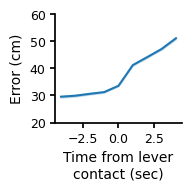

In [95]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=1)
ax = fig.add_subplot(mainSpec[0])
plot_line_plot_condition(ax,condition="all_dark",inputDf=df_model_distance)


In [96]:
def plot_autopi_stats(spec):

    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=4, nrows=1, width_ratios=[2,1,1,1] ,subplot_spec=spec[0])
    
    pathSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=mainSpec[0])
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=1,subplot_spec=mainSpec[1:])


    plot_light_dark_trial_array(pathSpec)

    ax = fig.add_subplot(plotSpec[0])
    plot_mvl_per_condition(ax)

    ax = fig.add_subplot(plotSpec[1])
    plotGridRotation(ax)
    

    ax = fig.add_subplot(plotSpec[2])
    plot_line_plot_condition(ax,condition="all_dark",inputDf=df_model_distance)


Stats on prediction heading accuracy in RF, L and D conditions
Wilcoxon test RF2-L, N: 24, stats: 35.0, P = 0.0004944801330566406
Wilcoxon test L-D, N: 24, stats: 3.0, P = 5.960464477539062e-07


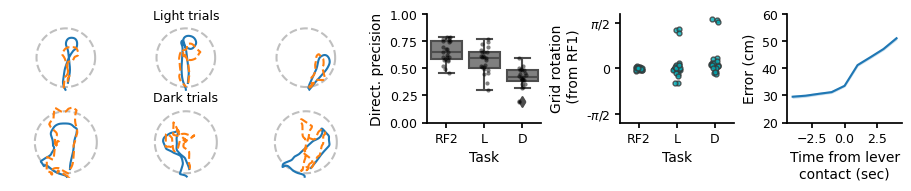

In [97]:
rowSize,colSize= figurePanelDefaultSize()
setFigureDefaultParameters()
ncols=5
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=1, nrows=1)
plot_autopi_stats(mainSpec)



In [98]:
if:

SyntaxError: invalid syntax (879943805.py, line 1)

# Add shuffle data

In [99]:
minSpeed = 10
dfOFSel = dfOF[(dfOF.speed > minSpeed)&(dfOF.session.isin(selectedSessionNames))]
dfAutoPISel =  dfAutoPI[(dfAutoPI.speed > minSpeed) & (dfAutoPI.speed < maxSpeed)& (dfAutoPI.shortCondition.isin(["L","D"])) & (dfAutoPI.session.isin(selectedSessionNames))]

cols = ["mouse","session","shortCondition","mvtDirError"]
dfConcatenated = pd.concat([dfAutoPISel[cols], dfOFSel[cols]])
res = dfConcatenated.groupby(["session","shortCondition"]).apply(vl_wrapper).reset_index()

res.columns = ["session","shortCondition","mvl"]
res.shortCondition[res.shortCondition=="RF"] = "RF2"

In [100]:
res[res.mvl < 0.3]

,session,shortCondition,mvl
3,jp3120-25052022-0107,D,0.200180
6,jp3120-26052022-0107,D,0.193527


In [101]:
allSessPlusDfOf = pd.concat([dfAutoPISel,dfOFSel])

In [102]:
def getSessionSliceMVL(sesName = 'jp452-25112022-0110'):
    sessionSlice = allSessPlusDfOf[allSessPlusDfOf.session == sesName].copy()
    sessionSlice = sessionSlice[(sessionSlice.speed > 10)].reset_index().copy()
    return sessionSlice

In [103]:
def get_mvt_direction_error_on_the_go(inputDf):
    """
    Calculate the movement direction error between real and predicted movement direction
    
    mvt is v1
    predMvt is v2
    
    Gives the angle between the vectors in a counterclockwise direction from v1 to v2. 
    
    v1 is [x1,y1] and v2 is [x2,y2]
    
    atan2d(x1*y2-y1*x2,x1*x2+y1*y2)
    
    If that angle would exceed 180 degrees, then the angle is measured in the clockwise direction but given a negative value. 
    In other words, the output of 'atan2d' always ranges from -180 to +180 degrees.
    
    
    If the mvt is (1,0) and predMvt is (1,1), we get a positive error (0.785)
    If the mvt is (1,0) and predMvt is (1,-1), we get a positive error (-0.785)
    
    If predMvt is (0,-1) and mvt is (1,-1), we get a negative error (-0.785)
    If predMvt is (0,-1) and mvt is (-1,-1), we get a positive error (0.785)
    
    
    """
    # getting the direction of our vectors
    mvtDir = np.arctan2(inputDf.loc[:,"y"],inputDf.loc[:,"x"])
    predMvtDir = np.arctan2(inputDf.loc[:,"py"],inputDf.loc[:,"px"])
    
    # use cos to get the x and sin to get the y
    mvtDirError = np.arctan2(np.cos(mvtDir)*np.sin(predMvtDir)-np.sin(mvtDir)*np.cos(predMvtDir),
                             np.cos(mvtDir)*np.cos(predMvtDir)+np.sin(mvtDir)*np.sin(predMvtDir))
    return mvtDirError



def vl_mvt_direction_error_on_the_go(inputDf):
    """
    Calculate the mean direction of the mvt direction error
    """
    
    mvtDirError = get_mvt_direction_error_on_the_go(inputDf)
    
    xMean = np.mean(np.cos(mvtDirError))
    yMean = np.mean(np.sin(mvtDirError)) 
    return np.sqrt(xMean*xMean+yMean*yMean)



In [104]:
# mvlHolder = []
# sesHolder = []
# condHolder = []
# shuffleIter = []
# for ses in tqdm(selectedSessionNames):
#     sesSlice = getSessionSliceMVL(ses)
#     for condition in ['RF','all_light','all_dark']:

#         sesSliceO = sesSlice[sesSlice.condition == condition].copy()

#         for i in range(1000):
#             start = 1000
#             end = len(sesSliceO) - start
#             #num_rows = np.random.randint(start, end)

#             sesSliceO.loc[:, 'px'] = np.roll(sesSliceO.loc[:, 'px'], shift=np.random.randint(start, end))
#             sesSliceO.loc[:, 'py'] = np.roll(sesSliceO.loc[:, 'py'], shift=np.random.randint(start, end))
        
#             mvl = vl_mvt_direction_error_on_the_go(sesSliceO)

#             mvlHolder.append(mvl)
#             sesHolder.append(ses)
#             condHolder.append(condition)
#             shuffleIter.append(i)

# outputDf = pd.DataFrame({'session':sesHolder,'condition':condHolder,'mvl':mvlHolder,'shuffleIter':shuffleIter})

In [105]:
# perCHolder = []
# sesHolder = []
# condHolder = []

# for sesName in selectedSessionNames:
#     for condition in ['RF','all_light','all_dark']:
#         #perc = np.percentile(outputDf[(outputDf.session == sesName)&(outputDf.condition == condition)].mvl,95)
#         perc = outputDf[(outputDf.session == sesName)&(outputDf.condition == condition)].mvl.quantile(0.95)
#         perCHolder.append(perc)
#         sesHolder.append(sesName)
#         condHolder.append(condition)

# shufflePercDf = pd.DataFrame({'session':sesHolder,'condition':condHolder,'mvl':perCHolder})
# shufflePercDf.replace({'RF':'RF2','all_light':'L','all_dark':'D'},inplace=True)
# shufflePercDf.rename(columns = {'condition':'shortCondition'}, inplace = True)

In [106]:
# shufflePercDf['realOrShuffle'] = 'Shuffle'

In [107]:
# res['realOrShuffle'] = 'Real'
# allResDf = pd.concat([res,shufflePercDf])

In [108]:
#allResDf.to_csv("model_mvl_shuffled.csv",index=False)

In [109]:
allResDf = pd.read_csv("model_mvl_shuffled.csv")

In [110]:
allResDf

,session,shortCondition,mvl,realOrShuffle
0,jp1686-26042022-0108,D,0.451686,Real
1,jp1686-26042022-0108,L,0.484346,Real
2,jp1686-26042022-0108,RF2,0.577187,Real
3,jp3120-25052022-0107,D,0.200180,Real
4,jp3120-25052022-0107,L,0.302326,Real
...,...,...,...,...
139,jp452-23112022-0108,L,0.085771,Shuffle
140,jp452-23112022-0108,D,0.102744,Shuffle
141,jp1686-26042022-0108,RF2,0.057310,Shuffle
142,jp1686-26042022-0108,L,0.091811,Shuffle


In [111]:
from statannotations.Annotator import Annotator

def plot_mvl_per_condition_shuffle(ax,printStats=True):

    pal = {"Shuffle": "#d9d9d9", "Real": OBSERVATIONCOLOR}

    b = sns.boxplot(data=allResDf,x="shortCondition",y="mvl",hue='realOrShuffle', order=["RF2","L","D"],palette=pal,**boxplot_kwargs,showfliers=False)
    sns.stripplot(data=allResDf,x="shortCondition",y="mvl",hue='realOrShuffle', order=["RF2","L","D"],palette=pal,legend=False,dodge=True,**stripplot_kwargs) #,hue="mouse")
    ax.set_ylim(0,1)

    ax.set_xlabel("Task")
    ax.set_ylabel("Direct. precision")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


    b.get_legend().remove()
    ax.set_yticks([0,0.5,1])
    ax.set_yticklabels(["0","0.5","1"])



    pairs = [[('L','Real'),('D','Real')],[('RF2','Real'),('L','Real')]]
    
    annotator = Annotator(b, pairs, data=allResDf,x="shortCondition",y="mvl",hue='realOrShuffle', order=["RF2","L","D"])
    annotator.reset_configuration()
    annotator.configure(test='Wilcoxon', text_format='star', loc='inside') #Wilcoxon, Mann-Whitney
    annotator.apply_and_annotate()

    if printStats:
        print("Stats on prediction heading accuracy in RF, L and D conditions")
        stat,P = wilcoxon(x=res.mvl[res.shortCondition=="RF2"] , y=res.mvl[res.shortCondition=="L"])
        print("Wilcoxon test RF2-L, N: {}, stats: {}, P = {}".format(len(res.mvl[res.shortCondition=="RF2"]),stat,P))
        stat,P = wilcoxon(x=res.mvl[res.shortCondition=="L"] , y=res.mvl[res.shortCondition=="D"])
        print("Wilcoxon test L-D, N: {}, stats: {}, P = {}".format(len(res.mvl[res.shortCondition=="D"]),stat,P))

    

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L_Real vs. D_Real: Wilcoxon test (paired samples), P_val:5.960e-07 Stat=3.000e+00
RF2_Real vs. L_Real: Wilcoxon test (paired samples), P_val:4.945e-04 Stat=3.500e+01
Stats on prediction heading accuracy in RF, L and D conditions
Wilcoxon test RF2-L, N: 24, stats: 35.0, P = 0.0004944801330566406
Wilcoxon test L-D, N: 24, stats: 3.0, P = 5.960464477539062e-07


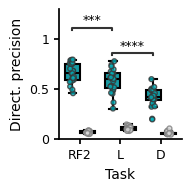

In [112]:
rowSize,colSize= figurePanelDefaultSize()
ncols=1
nrows=1
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
mainSpec = fig.add_gridspec(ncols=ncols, nrows=1)
ax = fig.add_subplot(mainSpec[0])
plot_mvl_per_condition_shuffle(ax)


In [113]:
def plot_autopi_stats_shuffle(spec):

    mainSpec = gridspec.GridSpecFromSubplotSpec(ncols=4, nrows=1, width_ratios=[2,1,1,1] ,subplot_spec=spec[0])
    
    pathSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1,subplot_spec=mainSpec[0])
    plotSpec = gridspec.GridSpecFromSubplotSpec(ncols=3, nrows=1,subplot_spec=mainSpec[1:])


    plot_light_dark_trial_array(pathSpec)

    ax = fig.add_subplot(plotSpec[0])
    plot_mvl_per_condition_shuffle(ax)

    ax = fig.add_subplot(plotSpec[1])
    plotGridRotation(ax)
    

    ax = fig.add_subplot(plotSpec[2])
    plot_line_plot_condition(ax,condition="all_dark",inputDf=df_model_distance)

In [114]:
import matplotlib.patches as mpatches

def add_r_s_legend(ax,anchorPos = (0.503,0.18)):
    legend_labels = ['Real','Shuffle']
    legend_colors = [OBSERVATIONCOLOR,'#d9d9d9']

    handles = [mpatches.Patch(color=color, label=label) for color, label in zip(legend_colors, legend_labels)]
    ax.legend(handles = handles,fontsize= 9, frameon=False,loc='lower left', bbox_to_anchor = anchorPos)


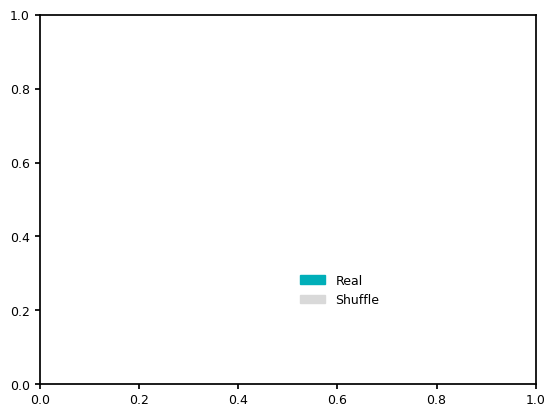

In [115]:
fig, ax =plt.subplots()
add_r_s_legend(ax)

In [116]:
rowSize

1.8

In [118]:
if: 

SyntaxError: invalid syntax (1786429152.py, line 1)

# New figure with schematics

(-0.5, 7979.5, 1371.5, -0.5)

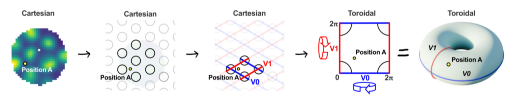

In [119]:
fig, ax =plt.subplots()
img = mpimg.imread('/home/kilo/repo/analysis_jingjie/jingjie/autopi_mec_jingjie/autopi_mec/Jingjie/figure2/schematic_cartesian_to_toroidal_3.png')
ax.imshow(img)
ax.axis("off")

In [120]:
rowSize,colSize= figurePanelDefaultSize()
#rowSize,colSize= 2,2

ncols=5.0
nrows=5.5
fig = plt.figure(figsize=(ncols*colSize, nrows*rowSize), constrained_layout=True) # create a figure
spec = fig.add_gridspec(ncols=2, nrows=10,width_ratios=[0.01,1],height_ratios=[0.01,1,0.01,1,0.1,1.2,0.1,1.1,0.1,1.0]) 

figSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[1,1])
transSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[3,1])
modelSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[5,1])
statsSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[7,1])
autopiSpec = gridspec.GridSpecFromSubplotSpec(ncols=1, nrows=1, subplot_spec=spec[9,1])


ax0 = fig.add_subplot(figSpec[0,0])
img = mpimg.imread('/home/kilo/repo/analysis_jingjie/jingjie/autopi_mec_jingjie/autopi_mec/Jingjie/figure2/schematic_cartesian_to_toroidal_3.png')
ax0.imshow(img)
ax0.axis("off")

transformation_plot(transSpec)
model_plot(modelSpec)
statsRowNew(statsSpec)
plot_autopi_stats_shuffle(autopiSpec)


ax = fig.add_subplot(spec[:,:]) # add an axes to the figure
ax.text(0,0.99, 'a', style='normal',fontsize=13, weight="bold")
ax.text(0,0.81, 'b', style='normal',fontsize=13, weight="bold")
ax.text(0,0.61, 'c', style='normal',fontsize=13, weight="bold")

ax.text(0,0.39, 'd', style='normal',fontsize=13, weight="bold")
ax.text(0.22,0.39, 'e', style='normal',fontsize=13, weight="bold")
ax.text(0.61,0.39, 'f', style='normal',fontsize=13, weight="bold")
ax.text(0.82,0.39, 'g', style='normal',fontsize=13, weight="bold")

ax.text(0,0.18, 'h', style='normal',fontsize=13, weight="bold")
ax.text(0.42,0.18, 'i', style='normal',fontsize=13, weight="bold")
ax.text(0.61,0.18, 'j', style='normal',fontsize=13, weight="bold")
ax.text(0.82,0.18, 'k', style='normal',fontsize=13, weight="bold")

add_r_s_legend(ax,anchorPos =(0.503,0.145))

ax.axis("off")

Pearson correlation, number grid cells, pred MVL:
N:49, r:0.7361451243210786, p:1.6663404908836179e-09
1.6663404908836179e-09
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

L_Real vs. D_Real: Wilcoxon test (paired samples), P_val:5.960e-07 Stat=3.000e+00
RF2_Real vs. L_Real: Wilcoxon test (paired samples), P_val:4.945e-04 Stat=3.500e+01
Stats on prediction heading accuracy in RF, L and D conditions
Wilcoxon test RF2-L, N: 24, stats: 35.0, P = 0.0004944801330566406
Wilcoxon test L-D, N: 24, stats: 3.0, P = 5.960464477539062e-07


(0.0, 1.0, 0.0, 1.0)